# 11. Attention Mechanisms and Transformers

- ReLU, BatchNorm과 같은 다양한 기법들이 등장하였지만
- 필수적인 Design 요소는 지난 30년간 크게 바뀐 것 없었고 컴퓨터 성능과 방대한 데이터가 DNN의 성장 동인이 되어 왔다.
- 하지만 Transformer 등의 새로운 아키텍쳐가 등장하면서 DNN 분야에 새로운 성장을 이루어내고 있다.
- 대부분의 NLP의 모델이 Transformer를 기반으로 하고 있으며 새로운 Task를 다룰 때 첫번째 고려대상으로 인식되고 있다.
- NLP뿐아니라 Vision 영역에서 ViT (Vision Transformer) 등이 주목받고, Speech Recognition, Reinforcement Learning, Graph Neural Network 등 많은 다른 분야에 사용되고 있다.

## Idea behind transformers

- Seq2Seq (e.g. machine translation) 모델의 성능을 개선하기 위해 최초로 개발되었다. 
- Decoder가 입력 Sequence에 따라 특정 부분에 더욱 가중치를 둘 수 있도록 하기 위한것으로써 설계.
  - Encoder는 입력 Sequence와 같은 크기의 Representation을 생성하고 Decoder는 이 Repr.의 Weighted Sum으로 이루어진 Context Vector를 입력으로 받아 새로운 Seqeunce를 생성
  - 여기서 Weight은 Sequence의 각 요소에 얼마 집중할 것인지를 나타냄
  - 그리고 이 Weight를 할당하는 과정이 미분 가능하며 다른 paramter와 같이 학습 가능함.
- 기존의 Seq2Seq SOTA를 갈아치우며 RNN 기반 Seq2Seq의 성공적인 개선으로써 도입됨.
- 게다가 일부 Seq2Seq에서 대응 단어에 높은 Weight을 할당하는 등과 같이 매우 직관적인 해설(Interpretability)을 제공

## Dominance of Transformers

- 단순히 Seq2Seq에서 Salient Input을 선별하는 것에 그치지 않고 Vaswani 등에 의해 온전히 Transformer를 기반으로한 Machine Translation 방식이 제안('17)되었고 당시 최고 성능의 모델을 넘어서면서 주목받기 시작
- NLP에 Transformer가 새로운 기준으로 수용되고 이러한 모델들이 기존의 SOTA를 갈아치우기 시작함.
- NLP의 지배적인 설계 접근 방식으로써...
  - 다양한 광범위한 Corpora (Text Dataset)을 이용..
  - Self-supervised 방식의 Pre-training
  - Downstream Task 데이터를 이용한 Fine-Tuning
- Pretraining Paradigm을 적용한 이후 기존의 Architecture 기반의 모델과의 Gap이 더욱 극대화됨..



## Queries, Keys and Values

- 많은 DNN 모델들이 학습 및 추론의 효율성을 위해 fixed input size에 의존함.
- 이러한 fixed input size는 다양한 길이의 Text를 다루는 NLP에서 문제점으로 작용.
- 이러한 문제점의 해결방안으로써 Recurrent Architecture를 이용하여 입력을 순차적인 방식으로 처리하거나..
- 특수하게 설계된 Conv Kernel을 이용하는 등의 접근이 있어왔다...
- 하지만 Sequence의 길이가 길어질 수록 아래와 같은 다양한 문제점들이 발생
  - 낮은 연산 효율성
  - 과도한 메모리 사용
  - 멀리 떨어진 정보간의 의존성

### Database와의 비유
- Database는 Key-Value pair로 구성된 데이터 집합으로 Query를 통해 특정 정보를 요청할 수 있다.
- 이때 Query는 Database의 Size의 변화와 상관 없이 Design 될 수 있으며 이러한 변화에 대해 효율성의 저하가 없다.
- 또 한편으로는 Database의 정보의 복잡도와 크기에 어떠한 제약이 없으며, 이러한 복잡도의 증가가 Query의 효율성에 영향을 주지 않는다.
- 데이터베이스에 포함된 정보에 따라 같은 Query에 대해 다른 결과가 나올 수 있다.
- Attention Mechanism은 이러한 Database의 Query의 특징에 영감을 받아 고안되었다.
- 이를 통해 주어진 Query에 따라 Model이 입력의 특정 영역에 보다 집중할 수 있도록 설계되어졌다. (이는 Database가 주어진 Query에 대해 특정 K-V pair에 집중하는 것과 유사)

### Attention
- Attention Weight
  
  > a_i =  q_i@k_i
  
  - 각 attention weight는 convex cone
  - 각 attention의 합은 이러한 convex들의 조합으로 나타나며 (울퉁불퉁한 wave) 전체 합은 1이됨. (softmax)
  - 전체 element 중 한 weight가 1이면 앞의 특징들에 의해 나머지 elem. weight은 0이되며 이는 Databse의 query와 유사
  - 만약 모든 elem.의 weight가 uniform하게 같으면 결국 average pooling과 같음
  - (참고) 대표적인 특징에 있어서는 동일하나 상세 설계 등에 있어 다양. RL에 의해 학습되는 Non-differentiable Attention 도 있다. 

### Visualization
- Attention Mechanism은 weight의 총합이 1인 분포를 갖기 때문에 이것을 시각화하여 데이터간의 연관성 및 동작에 대한 직관을 얻을 수 있다.

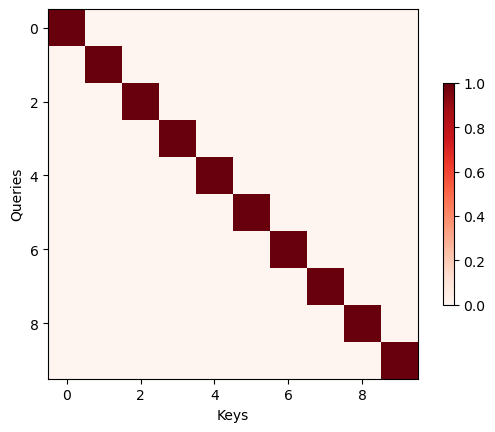

In [28]:
import torch
from matplotlib import pyplot as plt
def show_heatmaps(heatmaps: torch.Tensor, xlabel: str, ylable: str, cmap:str='Reds'):
    num_rows, num_cols, _ , _  = heatmaps.shape
    fig, axes = plt.subplots(num_rows, num_cols, squeeze=False, sharex=True, sharey=True)
    
    for i, (row_axes, row_map) in enumerate(zip(axes, heatmaps)):
        for j, (ax, map) in enumerate(zip(row_axes, row_map)):
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylable)
            pcm = ax.imshow(map.detach().numpy(), cmap=cmap)
    fig.colorbar(pcm, ax=axes, shrink=0.6)
    

attention_weights = torch.eye(10).reshape((1,1, 10, 10))
show_heatmaps(attention_weights, 'Keys', 'Queries')

## Attention Pooling by Similarity

- Attention 메커니즘을 kernel density estimation (kernel 밀도 계산)이라는 방법을 통해 회귀 분석 및 분류와 같은 고전적 접근에 활용하는 것을 학습

### Nadaraya-Watson Regression
- 임의의 관측으로 부터 특정 위치에서의 값을 추정하는 방식으로 다양한 non-parametric kernel (일정한 함수 형태로 주어지는..)을 이용하여 각 관측 값들의 weight를 구하고 이를 이들의 overall contribution을 통해 prediction을 구하는 regression 기법
- Gaussian, Boxcar, Epanechikov 등을 구현하여 테스트 해보고 Heatmap을 표시하여 각 kernel의 특성에 대한 interpretation을 얻는 것을 실습

In [29]:
import torch

def gaussian(x: torch.Tensor):
    return torch.exp(-x**2 / 2)

def boxcar(x:torch.Tensor):
    return torch.abs(x) < 1.0

def constant(x:torch.Tensor):
    return 1.0 + 0 * x

def epanechikov(x:torch.Tensor):
    return torch.max(1 - torch.abs(x), torch.zeros_like(x))

kernels = [
    ('Gaussian', gaussian),
    ('Boxcar', boxcar),
    ('Constant', constant),
    ('Epanechikov', epanechikov)
]



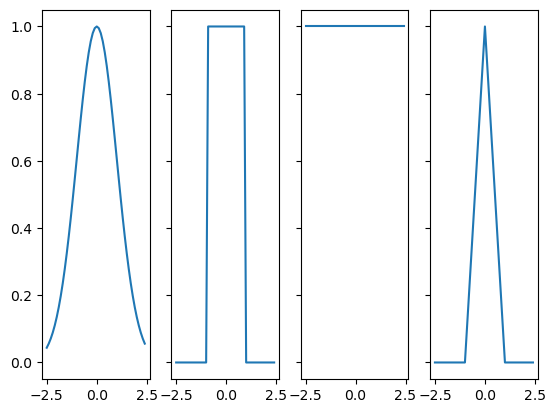

In [30]:
from matplotlib import pyplot as plt

fig, axes = plt.subplots(1, len(kernels), sharey=True)
x = torch.arange(-2.5, 2.5, 0.1)
for (name, kernel), ax in zip(kernels, axes):
    ax.plot(x.detach().numpy(), kernel(x).detach().numpy())


In [31]:
import torch

def f(x):
    return 2 * torch.sin(x) + x

n = 40

x_train, _ = torch.sort(torch.rand(n) * 5)
y_train = f(x_train) + torch.randn(n)
x_val = torch.arange(0, 5, 0.1)
y_val = f(x_val)



In [32]:
def nadaraya_watson(x_train, y_train, x_val, kernel):
    dists = x_train.reshape((-1, 1)) - x_val.reshape((1, -1))
    k = kernel(dists).type(torch.float32)
    attention_w = k / k.sum(0)
    y_hat = y_train @ attention_w
    return y_hat, attention_w



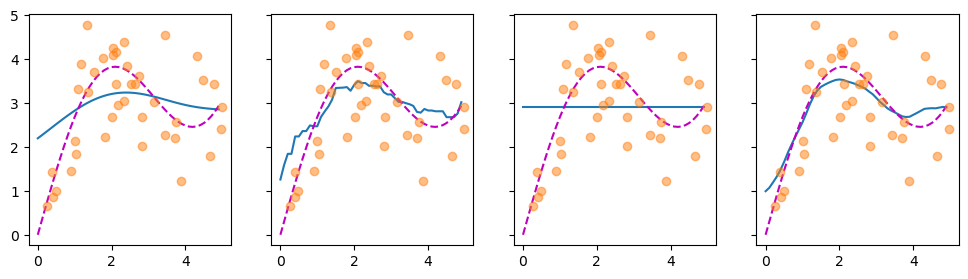

In [33]:
from matplotlib import pyplot as plt
def plot(x_train, y_train, x_val, y_val, kernels, attention=False):
    fig, axes = plt.subplots(1, len(kernels), sharey=True, figsize=(12,3))
    for (name, kernel), ax in zip(kernels, axes):
        y_hat, attention_w = nadaraya_watson(x_train=x_train, y_train=y_train, x_val=x_val, kernel=kernel)
        if attention:
            pcm = ax.imshow(attention_w.detach().numpy(), cmap='Reds')
        else:
            ax.plot(x_val, y_hat)
            ax.plot(x_val, y_val, 'm--')
            ax.plot(x_train, y_train, 'o', alpha=0.5)
    if attention:
        fig.colorbar(pcm, ax=axes, shrink=0.7)

plot(x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val, kernels=kernels)

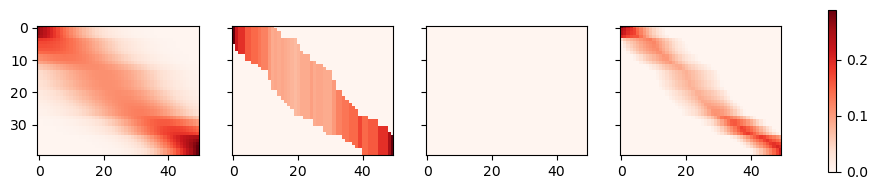

In [34]:
plot(x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val, kernels=kernels, attention=True)

In [37]:
from torch import nn, Tensor
import torch
import math

def masked_softmax(X: torch.Tensor, valid_lens):
    def _sequence_mask(X: torch.Tensor, valid_len, value=0):
        maxlen = X.size(1)
        # [None,:] is equivalent torch.Tensor.unsqueeze(0)
        mask = torch.arange((maxlen), dtype=torch.float32, device=X.device)[None,:] < valid_len[:,None]
        X[~mask] = value
        return X
    
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        
        X = _sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)
        

class DotProductAttention(nn.Module):
    
    def __init__(self, dropout:float, num_heads:int=None) -> None:
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.num_heads = num_heads
        
    def forward(self, queries: Tensor, keys: Tensor, values: Tensor, valid_lens:Tensor=None, window_mask:Tensor=None):
        d = queries.shape[-1]
        scores = torch.bmm(queries, keys.transpose(1,2)) / math.sqrt(d)
        if window_mask is not None:
            num_windows = window_mask.shape[0]
            batch, num_q, num_kv_pairs = scores.shape
            scores = scores.reshape((batch // (num_windows * self.num_heads), num_windows, self.num_heads, num_q, num_kv_pairs)) + window_mask.unsqueeze(1).unsqueeze(0)
            
        
        self.attention_weight = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weight), values)
        


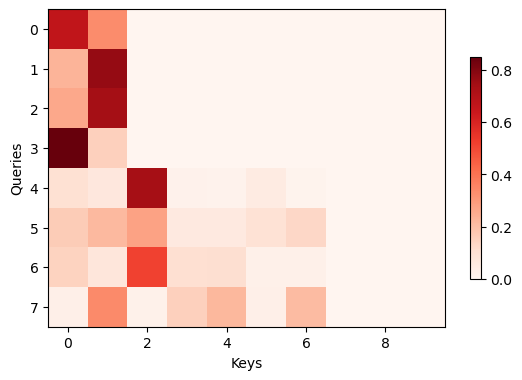

In [39]:
attention = DotProductAttention(dropout=0.5)

batch = 2
num_q, num_kv, qdim, vdim = 4, 10, 5, 10
queries = torch.randn((batch, num_q, qdim))
keys = torch.randn((batch, num_kv, qdim))
values = torch.randn((batch, num_kv, vdim))
valid_lens = torch.Tensor([2,7])

attention.eval()
result = attention(queries, keys, values, valid_lens)
# print(f'query {queries.shape}, keys {keys.shape}, values {values.shape} , result {result.shape}')
show_heatmaps(attention.attention_weight.reshape((1, 1, -1, 10)), xlabel='Keys', ylable='Queries')

### Additive Attention
- Query와 Key의 Dimension이 맞지 않을 경우 기존 Dot product attention의 경우 Q와 K사이에 Matrix를 하나 추가함으로써 이러한 문제를 해소하거나 혹은 Additive Attention을 사용할 수 있다. 
- Additive Attention의 또 하나의 장점은 덧샘연산을 사용하므로 연산의 효율이 높다는 것이다.
- 여기서 3개의 learnable parameters가 있으며 
  - Wq: Query를 hidden dimension으로 
  - Wk: Key를 hidden dimension으로 
  - Wv: 최종적으로 hidden dimension을 value dimension으로 


In [42]:
from torch import nn
class AdditiveAttention(nn.Module):
    
    def __init__(self, num_hiddens, dropout, **kwargs) -> None:
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.LazyLinear(num_hiddens, bias=False)
        self.W_q = nn.LazyLinear(num_hiddens, bias=False)
        self.W_v = nn.LazyLinear(1, bias=False)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        
        scores = self.W_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens=valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)
        

/home/fritzprix/miniconda3/envs/directml/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


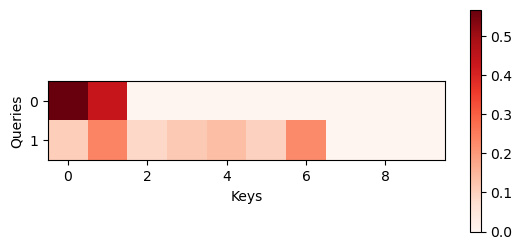

In [47]:
queries = torch.normal(0, 1, (2, 1, 20))
attention = AdditiveAttention(num_hiddens=8, dropout=0.1)
attention.eval()
score = attention(queries, keys, values, valid_lens)
show_heatmaps(attention.attention_weights.reshape((1, 1, -1, 10)), xlabel='Keys', ylable='Queries')

### Bahdanau Attention Mechanism

- 앞서 RNN 기반의 Seq2Seq 예시에서 Encoder는 입력 Sequence를 fixed-shape의 context variable로 변환하였다.
- Decoder는 바로 이 Context Variable에 전적으로 의존적으로 output sequence를 생성하였다.
- 다시 말하면 이는 **어떠한 입력에 대해서도 fixed shape이 충분한 정보를 함축하고 있는 것처럼 다루는 것이다.**

- 이는 상대적으로 짧은 Seq.에 대해서 어느정도 말이 되지만, 매우 길이가 긴 입력들 (가령 Chapter를 통째로 가져간다던가, 혹은 단순히 긴 문장일지라도...)에 대해서는 적절하지 않다.
- 결국에는 이러한 경우 정보를 충분히 전달하기에 **공간이 부족한 사태가 발생되고만다.**
- 